In [1]:
### using (7.66a), which f0*\bar{v*} + \bar{v'q'} equal m (v* mean vTEM)
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [3]:
# read variables
from scipy.fftpack import fft,ifft,fftfreq
file  = f"0404_300_50_8_variables.dat" # ./outputs/withprecip/

dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
v  = dycore.getVar("grid_v_c_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
sigma = p / ps
sigma_mean  = np.nanmean(sigma, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
Rd = 287
cp = 1004
g = 9.81
theta      = t * (ps / p)**(Rd/cp)
H = 6800
a = 6.37122e6

In [4]:
# # The edition without time mean
# def plot_V_W_50(pr):
#     file  = f"0404_300_50_8_variables.dat" # ./outputs/withprecip/
#     day = 300
#     dycore = Dycore(file)
#     # u  = dycore.getVar("grid_u_c_xyzt")
#     v  = dycore.getVar("grid_v_c_xyzt")
#     t  = dycore.getVar("grid_t_c_xyzt")
#     ps = dycore.getVar("grid_ps_xyzt")
#     p  = dycore.getVar("grid_p_full_xyzt")
#     sigma = p / ps
#     sigma_mean = np.nanmean(sigma, axis=(0,3))
#     sigma_onlyz = np.nanmean(sigma_mean, axis=1)
#     Rd = 287
#     cp = 1004
#     g = 9.81
#     theta             = t * (ps / p)**(Rd/cp)
#     H = 6800
#     # p0 = 100000
#     a = 6.37122e6
    
#     # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
#     # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
#     # Z_all     = H * np.log(p0/p)
#     rho_0     = np.zeros((20,64))
#     rho_0_all = np.zeros(((day,20,64)))
#     for i in range(0,20):
#         rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
#         rho_0_all[:,i,:] = np.nanmean(p[:,i,:,:], axis=2) / np.nanmean(ps[:,0,:,:], axis=2)                  # np.exp(-Z_all[:,i,:,:]/H) 
#     omega  = (dycore.getVar("grid_w_full_xyzt"))
#     w = omega  
#     ### do dz by dz = H * ln(ps/p)
#     THzm = np.nanmean(theta, axis=(3)) ######################
#     THETAz  = np.zeros(((day,20,64))) ############ 
#     p_onlyz = np.nanmean(p, axis=(0,2,3))
#     for i in range(1,19):
#         THETAz[:,i,:] = (THzm[:,i+1,:] - THzm[:,i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1]) #########
#     THETAz[:,0,:]  = (THzm[:,1,:]  - THzm[:,0,:])  /  (p_onlyz[1] - p_onlyz[0])
#     THETAz[:,-1,:] = (THzm[:,-1,:] - THzm[:,-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
#     THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
#     Vza = np.zeros(u.shape)
#     THETAza = np.zeros(u.shape)
#     Wza = np.zeros(u.shape)
    
#     Vzm = np.nanmean(v, axis=3)
#     THzm = np.nanmean(theta, axis=3)
#     for i in range(0,128):
#         Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
#         THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
#     VTHETA = Vza * THETAza
#     VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
#     # VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
#     Wzm = np.nanmean(w, axis=3)
#     Wzmtm = np.nanmean(Wzm, axis=0)
#     Vzm = np.nanmean(v, axis=(3)) #########
    
#     # phi
#     lat   = np.linspace(-90, 90, 64)
#     phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
#     lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
#     cphi  = np.cos(phi) 
#     acphi = a * cphi

#     # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
#     vTEM_temp = rho_0_all * VTHzm / THETAz ############################################
#     vTEM_tempdz = np.zeros(((day,20,64)))
#     for i in range(1,19):
#         vTEM_tempdz[:,i,:] = (vTEM_temp[:,i+1,:] - vTEM_temp[:,i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
#     vTEM_tempdz[:,0,:]  = (vTEM_temp[:,1,:]  - vTEM_temp[:,0,:]) /  (p_onlyz[1] - p_onlyz[0])
#     vTEM_tempdz[:,-1,:] = (vTEM_temp[:,-1,:] - vTEM_temp[:,-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
#     vTEM1 = Vzm #################
#     vTEM2 = (1/rho_0_all) * vTEM_tempdz
#     vTEM  = vTEM1 - vTEM2
#     # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
#     wTEM_temp =  cphi * VTHzm / THETAz ############################################
#     wTEM_tempdphi = np.zeros(((day,20,64)))
#     for i in range(1,63):
#         wTEM_tempdphi[:,:,i] = (wTEM_temp[:,:,i+1] - wTEM_temp[:,:,i-1]) / (phi[:,i+1] - phi[:,i-1])
#     wTEM_tempdphi[:,:,0]  = (wTEM_temp[:,:,1] - wTEM_temp[:,:,0]) /  (phi[:,1]  - phi[:,0])
#     wTEM_tempdphi[:,:,-1] = (wTEM_temp[:,:,-1] - wTEM_temp[:,:,-2]) / (phi[:,-1] - phi[:,-2])
    
#     wTEM1 = Wzm ##################
#     wTEM2 = (wTEM_tempdphi) /acphi
#     wTEM = wTEM1 + wTEM2

#     return vTEM,wTEM,p, ps, Wzmtm, rho_0
# vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(10)
# print("over")


In [5]:
# cal zonal mean and zonal anamoly
Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)

x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm  

In [6]:
# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy = np.cos(yd)
cy [0] = np.nan
cy [-1] = np.nan

In [7]:
### try to calculate balanced partial u partial t, which is calculated by TEM equation.
# first calculate zonal (v'q') (q is potential vorticity)
v  = dycore.getVar("grid_v_c_xyzt")
u  = dycore.getVar("grid_u_c_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
Rd = 287
cp = 1004

theta = t * (ps / p)**(Rd/cp)

Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
THzm = np.nanmean(theta, axis=3)
# THvm = np.nanmean(theta, axis=1)
Pzm = np.nanmean(p, axis=3)
Tzm = np.nanmean(t, axis=3)

In [8]:
Vzmtm  = np.nanmean(Vzm, axis=0)
Uzmtm  = np.nanmean(Uzm, axis=0)
THzmtm = np.nanmean(THzm, axis=0)
# THvmtm = np.nanmean(THvm, axis=0)
Pzmtm  = np.nanmean(Pzm, axis=0)
Tzmtm  = np.nanmean(Tzm, axis=0)

Vza     = np.zeros(u.shape)
Uza     = np.zeros(u.shape)
THETAza = np.zeros(u.shape)
Pza = np.zeros(u.shape)
Tza = np.zeros(t.shape)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm
    THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
    Pza[:,:,:,i]     = p[:,:,:,i] - Pzm
    Tza[:,:,:,i]     = t[:,:,:,i] - Tzm
    
M = Uza * Vza
Mzmtm = np.nanmean(M, axis=(0,3))

for i in range(1,64-1):
    Mzmtm[:,i] = cy[i]**0.5 * Mzmtm[:,i]

dmdy = np.zeros((20,64))
r = 6371e3
for i in range(1,64-1):
    dmdy[:,i] = -(Mzmtm[:,i+1] - Mzmtm[:,i-1]) / (r * (yd[i+1] - yd[i-1]))
dmdy[:, 0] = -(Mzmtm[:, 1] - Mzmtm[:, 0]) / (r*(yd[ 1] - yd[ 0]))
dmdy[:,-1] = -(Mzmtm[:,-1] - Mzmtm[:,-2]) / (r*(yd[-1] - yd[-2]))

Text(0.5, 1.0, "$\\overline{u'v'}$")

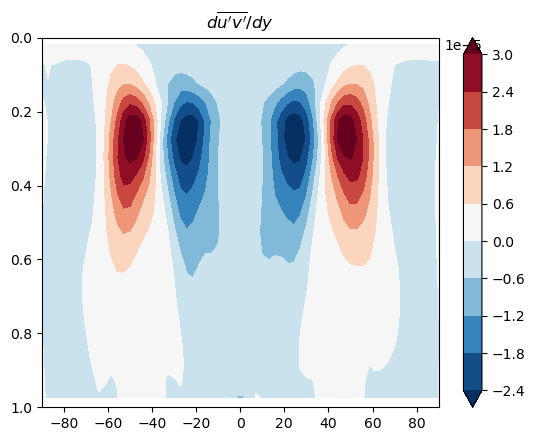

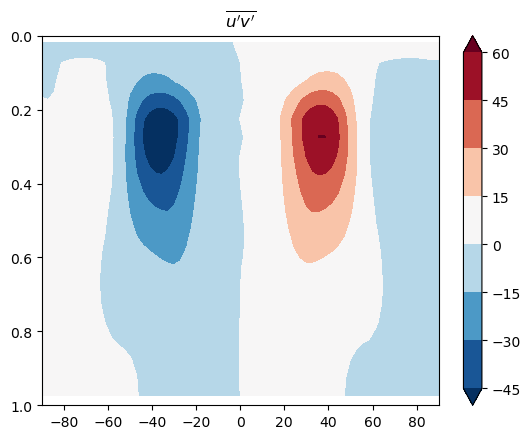

In [9]:
sigma_mean      = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
# vq_yz = np.nanmean(Vza * qza, axis=(0,3))

plt.figure()
plt.contourf(yy, sigma_mean2,  dmdy, levels= 11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$d\overline{u'v'} / dy$")

plt.figure()
plt.contourf(yy, sigma_mean2,  Mzmtm, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{u'v'}$")

(300, 20, 64, 128)
(300, 20, 64, 128)


Text(0.5, 1.0, "$\\overline{v'b'}$")

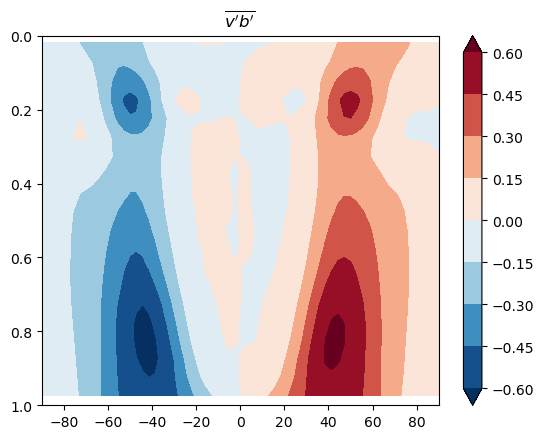

In [10]:
f0  = 2 * 7.292E-5 * np.sin(yd)
print(THETAza.shape)
# for i in range
# first mean y, then do three loop
bza =  THETAza / np.nanmean(theta, axis=0) * 9.81
print(bza.shape)
plt.figure()
plt.contourf(yy, sigma_mean2, np.nanmean(Vza * bza , axis=(0,3)),levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{v'b'}$")

In [11]:
from scipy.interpolate import interp1d
sigma_mean      = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

### ex z, ex theta, check plot z and theta, then cal N_square
# do ex z
from scipy import interpolate
N_square   = np.zeros(((300,20,64,128)))
# t is t\bar (z)
z = np.zeros(u.shape)
print(np.arange(-1,21))
for i in range(1,20-1):
    z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
##########
Pvm      = np.nanmean(p, axis=(0,2,3))

# print(z[0])
z_new = np.zeros((((300,22,64,128))))
theta_new = np.zeros((((300,22,64,128))))

for i in range(300):
    for j in range(64):
          for k in range(128):
            fe            = interp1d(np.linspace(0,20,20),z[i,:,j,k],  fill_value='extrapolate')
            z_new[i,:,j,k] = fe(np.linspace(-1,21,22))
            fe            = interp1d(np.linspace(0,20,20),theta[i,:,j,k],  fill_value='extrapolate')
            theta_new[i,:,j,k] = fe(np.linspace(-1,21,22))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


175.204769132857


Text(0.5, 1.0, 'theta and theta exterpolate')

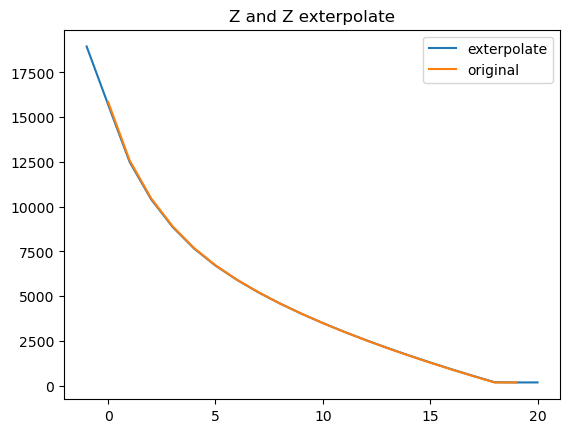

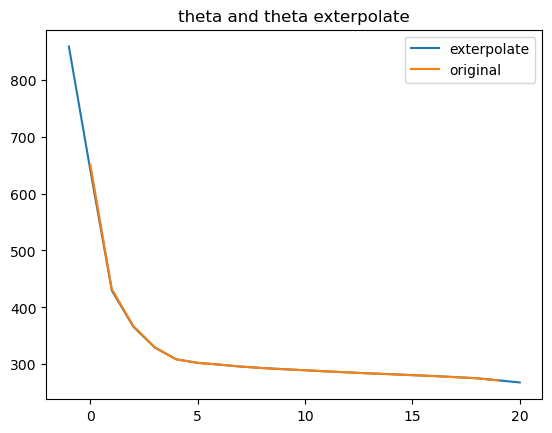

In [12]:
plt.figure()
plt.plot(np.arange(-1, 21), z_new[200,:,0,0], label='exterpolate')
print(z[200,-1,0,0])
plt.plot(np.arange( 0, 20), z[200,:,0,0], label='original')
plt.legend()
# plt.ylim([1,0])
# plt.colorbar()
# plt.title("N^2")
plt.title("Z and Z exterpolate")

plt.figure()
plt.plot(np.arange(-1, 21),theta_new[200,:,0,0], label='exterpolate')
plt.plot(np.arange( 0, 20),theta[200,:,0,0], label='original')
plt.legend()

plt.title("theta and theta exterpolate")

(300, 17, 64, 128)
over


Text(0.5, 1.0, 'N^2')

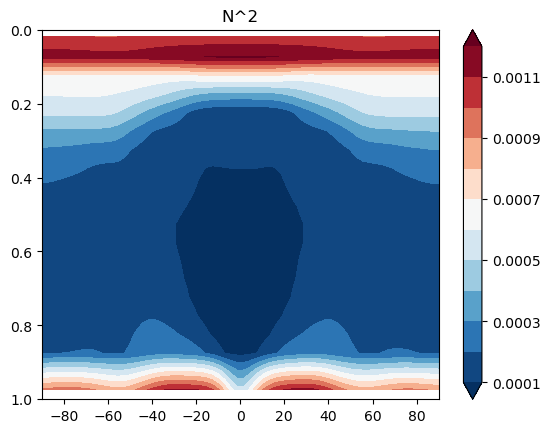

In [23]:
for i in range(1,20-1):
    N_square[:,i,:,:]   = 9.81 / theta[:,i,:,:] * (theta[:,i+1,:,:] - theta[:,i-1,:,:]) / (z[:,i+1,:,:]-z[:,i-1,:,:]) # original is partial z, but Dycore is on pressure (sigma) coord. so add minus
print(t[:,0:i-1,:,:].shape)

N_square[:, 0,:,:] = 9.81 / theta_new[:, 1,:] * (theta_new[:, 2,:] - theta_new[:, 0,:]) / (z_new[:,2,:,:]-z_new[:,0,:,:])

N_square[:,19,:,:] = 9.81 / theta_new[:,21,:,:] * (theta_new[:,21,:,:] - theta_new[:,18,:,:]) / (z_new[:,21,:,:]-z_new[:,18,:,:])
print("over")
# print(N_square[:,19,:,:])
# print(N_square[:,18,:,:])

plt.figure()
plt.contourf(yy, sigma_mean2, np.nanmean(N_square, axis=(0,3)),levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("N^2")

(20, 64)


Text(0.5, 1.0, "$\\overline{v'b'} / N^2 $")

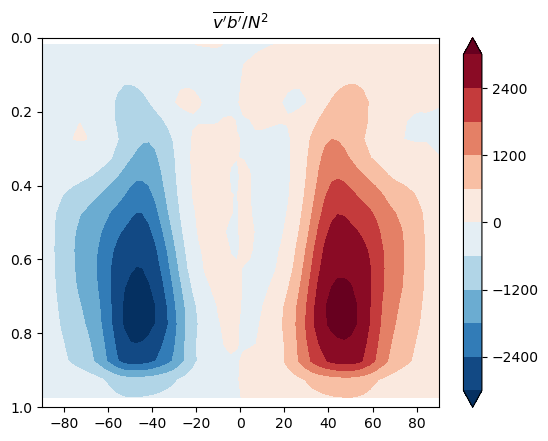

In [24]:
# do time for loop, then mean time and zonal
# MHF_raw = np.zeros(u.shape)
# for i in range(0,3):
    # MHF_raw[i,:,:,:]   = Vza[i,:,:,:] * bza[i,:,:,:]  / (N_square[i,:,:,:])  # mean meridional heat flux 
# MHF = np.nanmean(MHF_raw, axis=(0,3))
MHF = np.nanmean(Vza * bza, axis=(0,3)) / np.nanmean(N_square, axis=(0,3))
# MHF   = np.nanmean(Vza * bza, axis=(0,3))  / np.nanmean(N_square[0,:,:,:], axis=2) # mean meridional heat flux 
# MHF   = np.nanmean(MHF, axis=(0,2))

MHF_f = np.zeros(MHF.shape) # mean meridional heat flux 
p_mean = np.nanmean(p, axis=3)
for i in range(64):
    MHF_f[:,i] = MHF[:,i] * f0[i]
print(MHF.shape)
plt.figure()
# plt.yscale("log")
plt.contourf(yy, sigma_mean2,  MHF, levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{v'b'} / N^2 $")


0.0006498113002376715


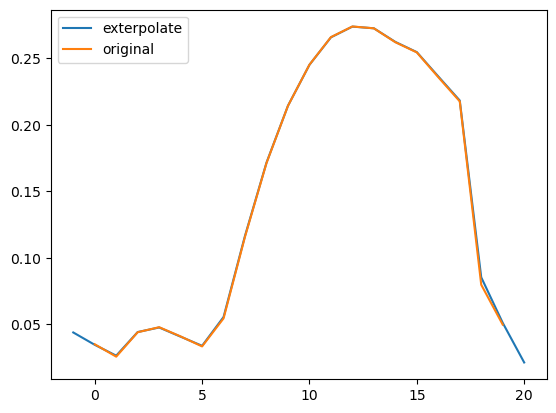

In [25]:
# calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
q2 = np.zeros((20,64))

H = 6800
for i in range(1,20-1):
    # z = Rd*np.nanmean(t[:,0:i,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
    q2[i,:] = (MHF_f[i+1,:] - MHF_f[i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(0,2)) 
print(np.nanmax(q2))

MHF_f_new = np.zeros((22,64))

for i in range(64):
    fe             = interp1d(np.linspace(0,20,20), MHF_f[:,i],  fill_value='extrapolate')
    MHF_f_new[:,i] = fe(np.linspace(-1,21,22))

# q2[ 0,:] = (MHF_f_new[ 2,:] - MHF_f_new[ 0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(0,2)) 
# q2[19,:] = (MHF_f_new[21,:] - MHF_f_new[19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(0,2)) 

plt.figure()
plt.plot(np.arange(-1, 21),MHF_f_new[:,10], label='exterpolate')
plt.plot(np.arange( 0, 20),MHF_f[:,10], label='original')
plt.legend()

# plt.title("theta and theta exterpolate")

Text(0.5, 1.0, "$\\partial (f_0 * \\overline{v'b'} / N^2) / \\partial z$")

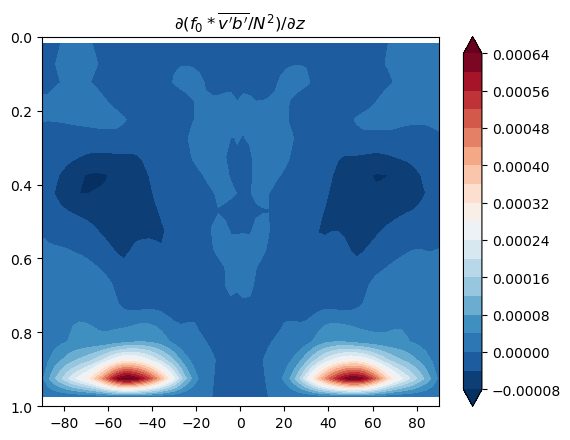

In [26]:
plt.figure()
plt.contourf(yy, sigma_mean2,  q2, levels=21, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\partial (f_0 * \overline{v'b'} / N^2) / \partial z$")

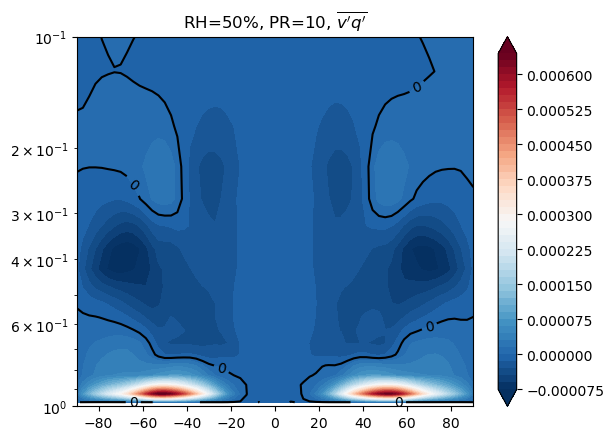

In [28]:
plt.figure()
plt.yscale('log')
plt.gca().invert_yaxis()
CS = plt.contourf(yy, sigma_mean2,  (q2+ dmdy) , levels=51, cmap="RdBu_r", extend="both")
CT = plt.contour(yy, sigma_mean2,  q2+ dmdy ,[0.0], colors='k')
plt.clabel(CT)
plt.ylim([1,0.1])
plt.colorbar(CS)
plt.title("RH=50%, PR=10, $\overline{v'q'}$")
# plt.savefig(r"paper1_fig/eq(7.66a)_fig/RH50_PR10//v'q'.png", bbox_inches='tight', dpi=600.)
plt.show()

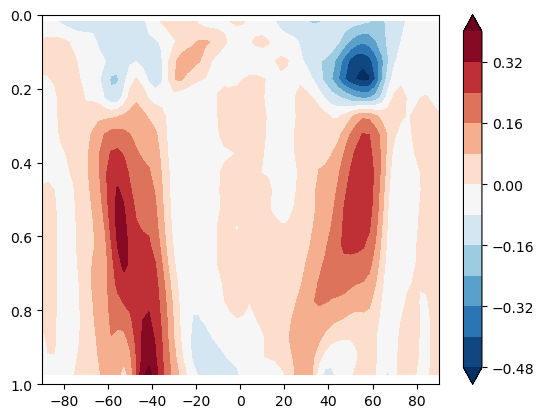

In [18]:
plt.figure()
plt.contourf(yy, sigma_mean2,  bza[300-1,:,:,100], levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()

Text(0.5, 1.0, "$\\overline{v' {\\ theta} '}$")

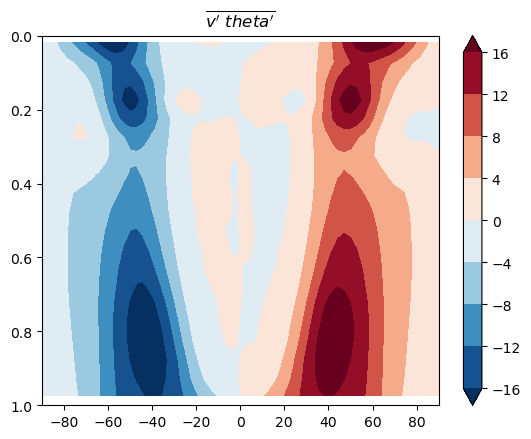

In [19]:
plt.figure()
plt.contourf(yy, sigma_mean2, np.nanmean(Vza * THETAza , axis=(0,3)),levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{v' {\ theta} '}$")